In [1]:
import pandas as pd
file_path = '/home/abrar/Desktop/Code/Temporal HPC/pm100_job _w_data_avg_power.csv'

# Read the second sheet (index 1, since indexing starts at 0)
df = pd.read_csv(file_path)

# Now 'df' contains the data from the second sheet

In [2]:
from tabulate import tabulate

print(tabulate(df.head(5), headers='keys', tablefmt='psql'))
# print(tabulate(df_filtered.head(), headers='keys', tablefmt='psql'))

+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [8]:
print(df['time_limit'].value_counts())

time_limit
1440    77921
30      30933
60      13370
240     11201
120     10154
        ...  
305         1
525         1
722         1
1409        1
285         1
Name: count, Length: 348, dtype: int64


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231125 entries, 0 to 231124
Data columns (total 42 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   cores_alloc_layout       231125 non-null  object 
 1   cores_allocated          231125 non-null  object 
 2   cores_per_task           231125 non-null  int64  
 3   derived_ec               231125 non-null  object 
 4   eligible_time            231125 non-null  object 
 5   end_time                 231125 non-null  object 
 6   group_id                 231125 non-null  int64  
 7   job_id                   231125 non-null  int64  
 8   job_state                231125 non-null  object 
 9   nodes                    231125 non-null  object 
 10  num_cores_req            231125 non-null  int64  
 11  num_cores_alloc          231125 non-null  int64  
 12  num_nodes_req            231125 non-null  int64  
 13  num_nodes_alloc          231125 non-null  int64  
 14  num_

In [4]:
# Calculate IQR for each column
Q1 = df[['mean_node_power', 'mean_cpu_power', 'mean_mem_power']].quantile(0.25)
Q1 = df[['mean_node_power', 'mean_cpu_power', 'mean_mem_power']].quantile(0.25)
Q3 = df[['mean_node_power', 'mean_cpu_power', 'mean_mem_power']].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows where values are outside bounds
filtered_df_IQR = df[
    (df['mean_node_power'] >= lower_bound['mean_node_power']) & 
    (df['mean_node_power'] <= upper_bound['mean_node_power']) &
    (df['mean_cpu_power'] >= lower_bound['mean_cpu_power']) & 
    (df['mean_cpu_power'] <= upper_bound['mean_cpu_power']) &
    (df['mean_mem_power'] >= lower_bound['mean_mem_power']) & 
    (df['mean_mem_power'] <= upper_bound['mean_mem_power'])
]

# Display summary of filtered dataset
# filtered_df_IQR.describe()

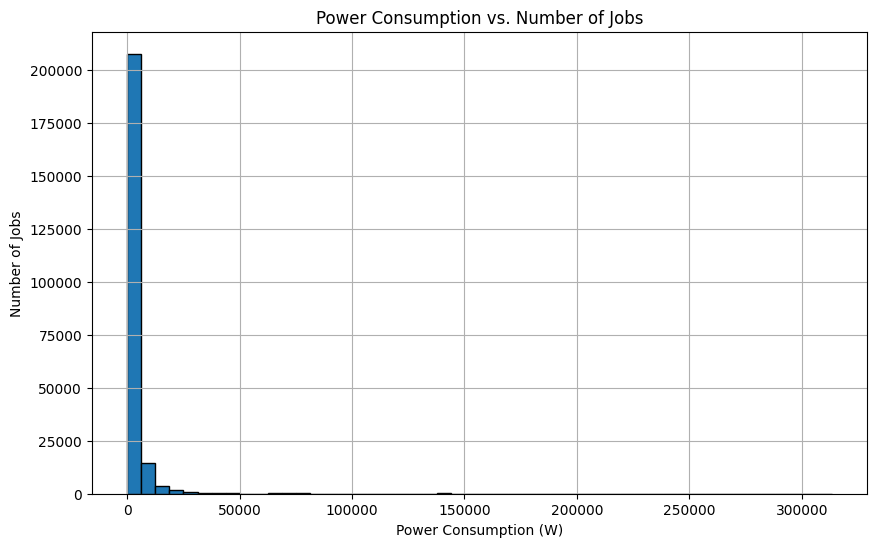

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming your DataFrame is named 'df'

# Convert relevant columns to numeric type if they are not already
df['mean_node_power'] = pd.to_numeric(df['mean_node_power'], errors='coerce')
df['mean_cpu_power'] = pd.to_numeric(df['mean_cpu_power'], errors='coerce')
df['mean_mem_power'] = pd.to_numeric(df['mean_mem_power'], errors='coerce')

# Calculate total power consumption per job
df['total_power_consumption'] = df['mean_node_power']  # Using mean_node_power as an example. 

#You can replace mean_node_power by either mean_cpu_power, mean_mem_power or by calculating sum of mean_cpu_power, mean_mem_power.

# Remove rows with NaN values in 'total_power_consumption' as these can't be plotted
df_filtered = df.dropna(subset=['total_power_consumption'])

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['total_power_consumption'], bins=50, edgecolor='black')  # Adjust bins as needed

# Add labels and title
plt.xlabel('Power Consumption (W)')
plt.ylabel('Number of Jobs')
plt.title('Power Consumption vs. Number of Jobs')

# Show the plot
plt.grid(True)
# plt.show()

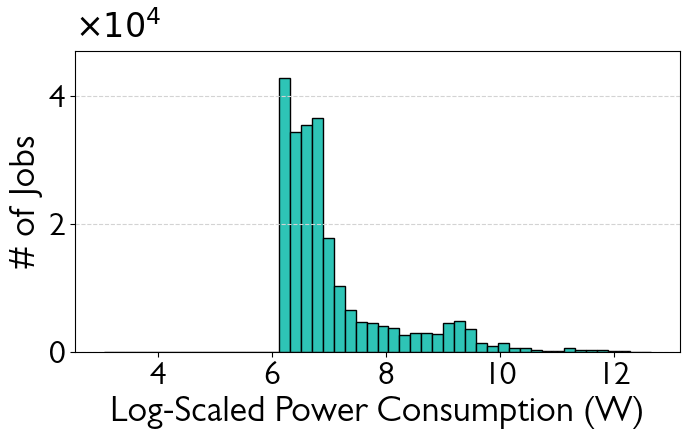

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter

# Set the font to Gill Sans
plt.rcParams['font.family'] = 'Gill Sans'

# Calculate dynamic y-axis limits
log_power = np.log1p(df_filtered['total_power_consumption'])
y_min, y_max = 0, np.histogram(log_power, bins=50)[0].max()
y_padding = y_max * 0.1  # Add 10% padding

# Adjusted histogram plot
fig, ax = plt.subplots(figsize=(7, 4.5))
ax.hist(log_power, bins=50, edgecolor='black', color='#2ec4b6')

# Update labels and limits
ax.set_xlabel('Log-Scaled Power Consumption (W)', fontsize=26)
ax.set_ylabel('# of Jobs', fontsize=26)
ax.set_ylim(0, y_max + y_padding)

# Adjust x-axis limits
x_min = log_power.min() - 0.5  # Add a buffer on the left
x_max = log_power.max() + 0.5  # Add a buffer on the right
ax.set_xlim(x_min, x_max)

# Customize x-axis ticks to be integers
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Customize y-axis ticks to show integers with 10^4 on top
def format_func(value, tick_number):
    return f'{int(value / 10000)}'

ax.yaxis.set_major_formatter(FuncFormatter(format_func))
ax.tick_params(axis='y', which='major', labelsize=24)
ax.text(0, 1.02, r'$\times 10^4$', transform=ax.transAxes, fontsize=24, va='bottom', ha='left')

# Customize ticks and gridlines
ax.tick_params(axis='x', which='major', labelsize=24)
ax.grid(which='both', axis='y', color='lightgrey', linestyle='dashed', zorder=0)

# Tight layout and save
plt.tight_layout()
plt.savefig("pm100_job_power.pdf", bbox_inches='tight')

# Show the plot
plt.show()


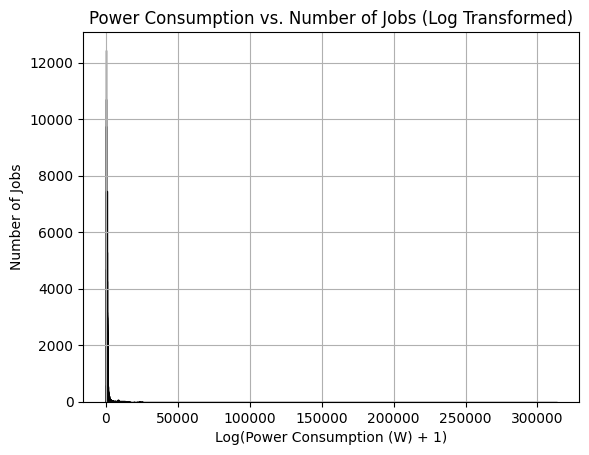

In [9]:
bin_edges = np.arange(0, df_filtered['total_power_consumption'].max() + 10, 10)  # Bins of width 1000
plt.hist(df_filtered['total_power_consumption'], bins=bin_edges, edgecolor='black')
# Update labels
plt.xlabel('Log(Power Consumption (W) + 1)')  # Reflect the transformation
plt.ylabel('Number of Jobs')
plt.title('Power Consumption vs. Number of Jobs (Log Transformed)')
plt.grid(True)
plt.show()

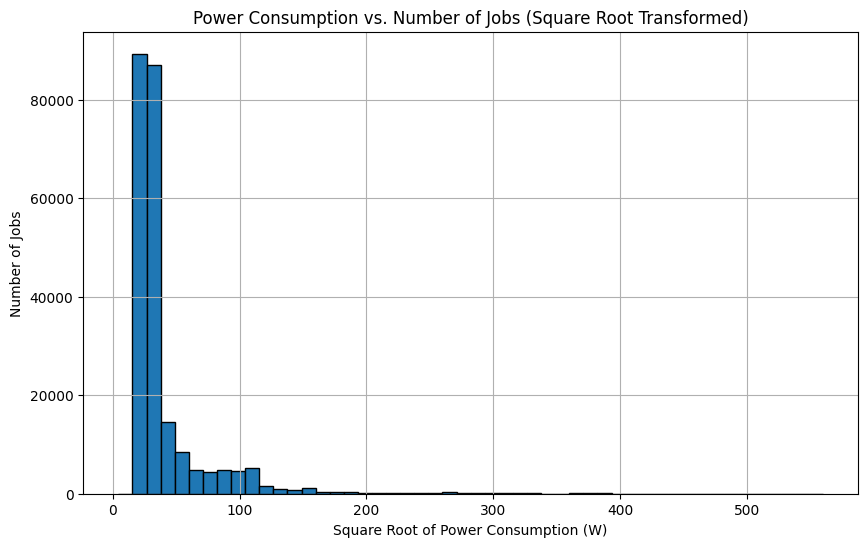

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(np.sqrt(df_filtered['total_power_consumption']), bins=50, edgecolor='black')

# Update labels
plt.xlabel('Square Root of Power Consumption (W)')
plt.ylabel('Number of Jobs')
plt.title('Power Consumption vs. Number of Jobs (Square Root Transformed)')
plt.grid(True)
plt.show()